
Label data type after encoding:
int32

First few rows of X after preprocessing:
     Duration  FlowBytesSent  FlowSentRate  FlowBytesReceived  \
0   95.081550        62311.0    655.342703            65358.0   
1  122.309318        93828.0    767.136973           101232.0   
2  120.958413        38784.0    320.639127            38236.0   
3  110.501080        61993.0    561.017141            69757.0   
4   54.229891        83641.0   1542.341289            76804.0   

   FlowReceivedRate  PacketLengthVariance  PacketLengthStandardDeviation  \
0        687.388878           7474.676771                      86.456213   
1        827.672018          10458.118598                     102.264943   
2        316.108645           7300.293933                      85.441758   
3        631.278898           8499.282518                      92.191553   
4       1416.266907           8052.745751                      89.737092   

   PacketLengthMean  PacketLengthMedian  PacketLengthMode  ...  \
0    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.17it/s]



Selected features using MRMR: ['Duration', 'PacketLengthVariance', 'FlowBytesSent', 'PacketTimeSkewFromMedian', 'PacketLengthMode', 'ResponseTimeTimeMean', 'ResponseTimeTimeSkewFromMedian', 'PacketLengthCoefficientofVariation', 'ResponseTimeTimeCoefficientofVariation', 'PacketTimeMode', 'ResponseTimeTimeMode', 'PacketLengthMean', 'PacketLengthMedian', 'PacketTimeCoefficientofVariation', 'FlowReceivedRate', 'PacketLengthStandardDeviation', 'PacketLengthSkewFromMode', 'ResponseTimeTimeStandardDeviation', 'PacketTimeSkewFromMode', 'FlowBytesReceived']

Accuracy: 0.9953618685044026

Classification Report:
              precision    recall  f1-score   support

         DoH       0.99      0.99      0.99     80889
      NonDoH       1.00      1.00      1.00    269252

    accuracy                           1.00    350141
   macro avg       0.99      0.99      0.99    350141
weighted avg       1.00      1.00      1.00    350141


Confusion Matrix:
[[ 79873   1016]
 [   608 268644]]


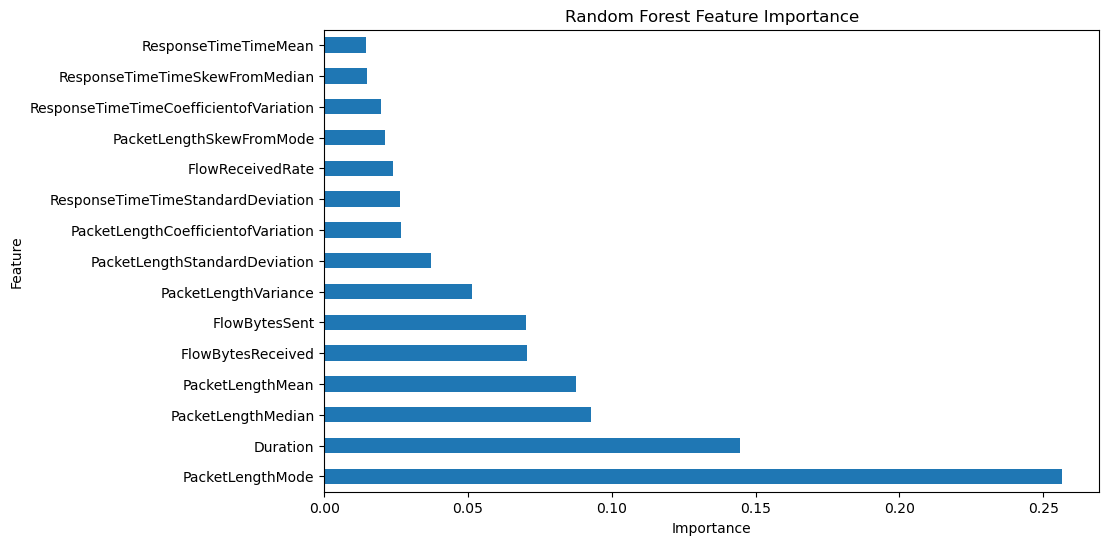

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import ipaddress
import matplotlib.pyplot as plt
from mrmr import mrmr_classif  # Import MRMR

# Initialize data type mappings for compatibility
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# Function to convert IP address to numeric
def ip_to_numeric(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except ValueError:
        raise ValueError(f"Invalid IP address encountered: {ip}")

# Load the datasets
doh_data = pd.read_csv('l1-doh.csv')
nondoh_data = pd.read_csv('l1-nondoh.csv')

# Add labels to the datasets
doh_data['Label'] = 'DoH'  # Label for DoH traffic
nondoh_data['Label'] = 'NonDoH'  # Label for non-DoH traffic

# Combine the datasets
data = pd.concat([doh_data, nondoh_data], ignore_index=True)

# Convert IP address columns to numeric
for ip_column in ['SourceIP', 'DestinationIP']:
    data[ip_column] = data[ip_column].apply(ip_to_numeric)

# Handle non-numeric values and unnecessary columns
numeric_columns = ['SourcePort', 'DestinationPort', 'Duration', 'FlowBytesSent', 'FlowSentRate',
                   'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance', 'PacketLengthStandardDeviation',
                   'PacketLengthMean', 'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
                   'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation', 'PacketTimeVariance',
                   'PacketTimeStandardDeviation', 'PacketTimeMean', 'PacketTimeMedian', 'PacketTimeMode',
                   'PacketTimeSkewFromMedian', 'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
                   'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation', 'ResponseTimeTimeMean',
                   'ResponseTimeTimeMedian', 'ResponseTimeTimeSkewFromMedian', 'ResponseTimeTimeSkewFromMode',
                   'ResponseTimeTimeCoefficientofVariation']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing values with imputation (mean strategy)
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Drop the 'TimeStamp', 'SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort' columns
data = data.drop(['TimeStamp', 'SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort'], axis=1)

# Separate features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Encode categorical target variable 'Label'
le = LabelEncoder()
y = le.fit_transform(y)

# Verify label encoding (should be numerical now)
print("\nLabel data type after encoding:")
print(y.dtype)

# Print first few rows and check for any unexpected string values
print("\nFirst few rows of X after preprocessing:")
print(X.head())

# Optional: Feature scaling (on features only)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame to calculate correlations
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate correlation matrix
correlation_matrix = X_scaled_df.corr()

# Display correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Identify highly correlated features (threshold > 0.9)
correlation_threshold = 0.9
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > correlation_threshold)]

# Drop highly correlated features
removed_features = []
for col in highly_correlated_features:
    corr_values = correlation_matrix.loc[correlation_matrix[col].abs() > correlation_threshold, col].to_dict()
    removed_features.append((col, corr_values))

X_scaled_df = X_scaled_df.drop(columns=highly_correlated_features)

# Check if any features are left
if X_scaled_df.shape[1] == 0:
    raise ValueError("No features left after removing highly correlated features. Adjust correlation threshold.")

print(f"\nHighly correlated features removed:")
for feature, corr_values in removed_features:
    print(f"Feature: {feature}, Correlation Values: {corr_values}")

# Apply MRMR for feature selection
selected_features = mrmr_classif(X_scaled_df, y, K=20)  # Adjust K as needed
print('\nSelected features using MRMR:', selected_features)

# Reduce the dataset to the selected features
X_selected = X_scaled_df[selected_features]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)

# Convert predictions back to original labels for classification report
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

# Print accuracy score
print('\nAccuracy:', accuracy_score(y_test, y_pred))

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test_original, y_pred_original))

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
print('\nConfusion Matrix:')
print(conf_matrix)

# Plot feature importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf.feature_importances_, index=X_selected.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
